# Example usage notebook of the DD-GAN repo

In [1]:
import time
import numpy as np
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
from copy import deepcopy

After installation of the ddgan package run the following line to import it

In [2]:
import ddgan
from ddgan import *

### Loading Data

In [3]:
nPOD = 10
nlatent = 100

evaluated_subdomains = 2
subdomains = 4
dims = 3
added_dims = [2,0,3]
cumulative_dims = [0,2,2]

steps = added_dims[-1]
start_from = 50 
datapoints = 1800 + steps + 100
step_size = 4

t_begin = 0
t_end = 1800

debug = False
train = True
find_old_model = False
noise = False #False
epochs = 2000 
n_gradient_ascent = 10


csv_data = np.load('../data/processed/DD/pod_coeffs_field_Velocity.npy', )

assert nPOD <= csv_data.shape[1], "Make sure the data includes enough POD coeffs"
assert datapoints + start_from <= csv_data.shape[2], "Not enough data"
assert evaluated_subdomains + 2 <= csv_data.shape[0], "Not enough domains"

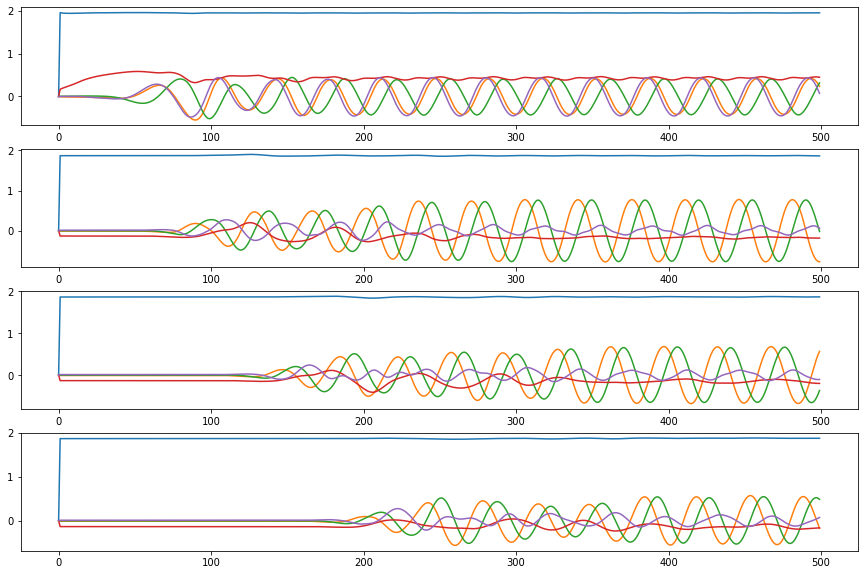

In [4]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(411)
ax1.plot(csv_data[0,:5,:500].T)
ax1 = fig.add_subplot(412)
ax1.plot(csv_data[1,:5,:500].T)
ax1 = fig.add_subplot(413)
ax1.plot(csv_data[2,:5,:500].T)
ax1 = fig.add_subplot(414)
ax1.plot(csv_data[3,:5,:500].T)

plt.show()

In [5]:
# Cutting the dataset
print(csv_data.shape)
csv_data = csv_data[:subdomains,:nPOD,start_from:start_from+datapoints]
print(csv_data.shape)

(4, 10, 2000)
(4, 10, 1903)


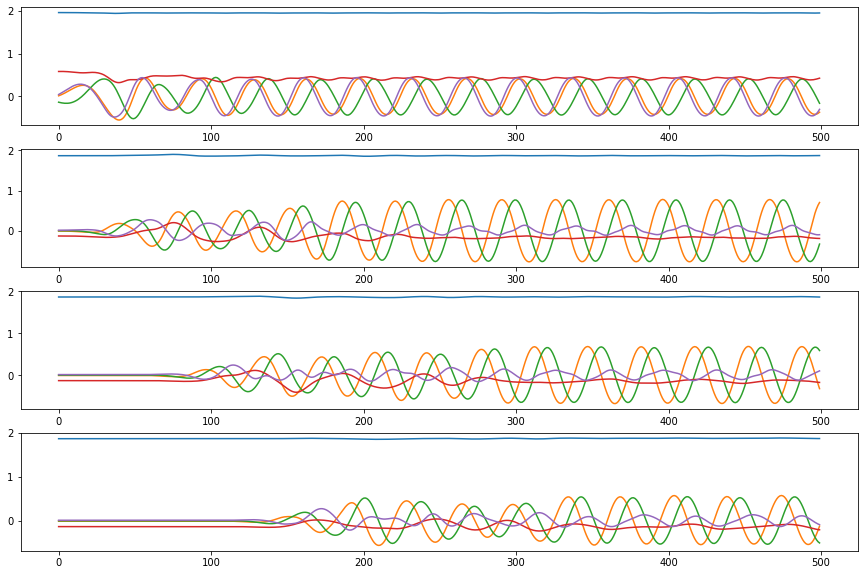

In [6]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(411)
ax1.plot(csv_data[0,:5,:500].T)
ax1 = fig.add_subplot(412)
ax1.plot(csv_data[1,:5,:500].T)
ax1 = fig.add_subplot(413)
ax1.plot(csv_data[2,:5,:500].T)
ax1 = fig.add_subplot(414)
ax1.plot(csv_data[3,:5,:500].T)

plt.show()

In [7]:
# Transposing data
tmp_data = np.ones([subdomains, datapoints, nPOD])

# Making a dataset for debugging purposes
new_data = np.ones([subdomains, nPOD, datapoints])
for i in range(subdomains):
    for j in range(nPOD):
        for k in range(datapoints):
            new_data[i][j][k] = nPOD*j + (i + 1)*10000 + k  

for k in range(subdomains):
    tmp_data[k] = csv_data[k].T
    if debug:
        tmp_data[k] = new_data[k].T
    
csv_data = tmp_data
csv_data.shape

(4, 1903, 10)

In [8]:
# Scaling
scales = []
scaled_training = np.zeros_like(csv_data)
if debug is False:
    for i in range(subdomains):
        scales.append(sklearn.preprocessing.MinMaxScaler(feature_range=[-1,1]))
        scaled_training[i] = scales[i].fit_transform(csv_data[i])
if debug:
    scaled_training = csv_data

In [9]:
# Asserting scaling is accurate
if debug is False:
    cond = np.zeros_like(scaled_training)
    for i in range(subdomains):
        cond[i] = scales[i].inverse_transform(scaled_training[i])
    assert np.allclose(csv_data[0,:,0], cond[0,:,0]), "Scaling failed"  

    for dim in range(subdomains):
        for icol in range(nPOD):
            assert np.isclose(np.min(scaled_training[dim][:,icol]) + np.max(scaled_training[dim][:,icol]), 0), "Scaling failed" 

In [10]:
# Setting up the data into subdomains 
# 2 x nTrain x nsteps * nPOD *3 # 'float32' or np.float32

assert sum(added_dims[:-1]) == cumulative_dims[-1]

training_data = np.zeros((evaluated_subdomains, t_end, np.sum(added_dims * nPOD)), dtype=np.float32) 

for domain in range(evaluated_subdomains): 
    for i, dim in enumerate([0,2,1]):
        for j, step in enumerate(range(steps-added_dims[i], steps)):
            training_data[domain, :, cumulative_dims[i]*nPOD + j*nPOD : cumulative_dims[i]*nPOD + (j+1)*nPOD] = scaled_training[dim + domain][t_begin+(step*step_size) : t_end+(step*step_size), :]

# Adding data for leftmost and rightmost domain
boundrary_conditions = []
boundrary_conditions.append(scaled_training[0, (steps-1)*step_size:])
boundrary_conditions.append(scaled_training[-1, (steps-1)*step_size:])

In [11]:
assert np.allclose(training_data[0,1,(added_dims[0]-1)*nPOD:added_dims[0]*nPOD], boundrary_conditions[0][1]), 'Check the boundrary condition data.'

In [12]:
joined_train_data = training_data.reshape((training_data.shape[1]*training_data.shape[0], training_data.shape[2]))

print(training_data.shape)
print(joined_train_data.shape)
print(tmp_data[0,steps-1:].shape)

(2, 1800, 50)
(3600, 50)
(1901, 10)


### Initializing GAN

In [13]:
kwargs = {
    "nsteps" : np.sum(added_dims),
    "ndims" : nPOD,
    "nLatent": nlatent,
    "batch_size" : 45,
    "batches" : 80,
    "seed" : 143,
    "epochs" : epochs,
    "noise" : noise,
    "n_gradient_ascent" : n_gradient_ascent,
    "logs_location" : './logs/gradient_tape/endless/',
    "model_location" : 'models/endless/'
}

gan = GAN(**kwargs)
gan.setup(find_old_model=find_old_model)
set_seed(gan.seed)

ndims_latent_input = gan.ndims
joined_train_data = np.float32(joined_train_data)
print('type and shape (nPOD by nTrain) of POD coeffs from csv file', type(joined_train_data), joined_train_data.shape, joined_train_data.dtype)

making new generator and critic
type and shape (nPOD by nTrain) of POD coeffs from csv file <class 'numpy.ndarray'> (3600, 50) float32


In [14]:
if train:
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir ./logs/gradient_tape/ --port 6008
    %reload_ext tensorboard

Reusing TensorBoard on port 6008 (pid 299), started 1:38:32 ago. (Use '!kill 299' to kill it.)

In [15]:
if train:
    gan.learn_hypersurface_from_POD_coeffs(joined_train_data)

beginning training
epoch: 	 0
gen loss:  -0.0041164304 d loss:  9.434713 w_loss:  -0.00669155
epoch: 	 1
gen loss:  -0.09569946 d loss:  4.043559 w_loss:  -0.10168034
epoch: 	 2
gen loss:  -0.20490722 d loss:  2.988867 w_loss:  -0.11349907
epoch: 	 3
gen loss:  -0.25591066 d loss:  2.436521 w_loss:  -0.11024151
epoch: 	 4
gen loss:  -0.30337065 d loss:  1.7439468 w_loss:  -0.069607966
epoch: 	 5
gen loss:  -0.36846715 d loss:  1.2162955 w_loss:  -0.006065231
epoch: 	 6
gen loss:  -0.46005386 d loss:  1.019625 w_loss:  0.062202096
epoch: 	 7
gen loss:  -0.49724454 d loss:  0.9215166 w_loss:  0.17080747
epoch: 	 8
gen loss:  -0.53399074 d loss:  0.89268225 w_loss:  0.26346886
epoch: 	 9
gen loss:  -0.5480842 d loss:  0.89616966 w_loss:  0.3215838
epoch: 	 10
gen loss:  -0.588662 d loss:  0.8794797 w_loss:  0.3457089
epoch: 	 11
gen loss:  -0.60019445 d loss:  0.9960604 w_loss:  0.35118476
epoch: 	 12
gen loss:  -0.5837479 d loss:  1.0967021 w_loss:  0.34713665
epoch: 	 13
gen loss:  -0.5

gen loss:  0.71159256 d loss:  0.24164565 w_loss:  0.13330618
epoch: 	 113
gen loss:  0.6963521 d loss:  0.26311016 w_loss:  0.10941372
epoch: 	 114
gen loss:  0.7344793 d loss:  0.3183674 w_loss:  0.06713497
epoch: 	 115
gen loss:  0.68587404 d loss:  0.24954052 w_loss:  0.14184043
epoch: 	 116
gen loss:  0.6562195 d loss:  0.28758916 w_loss:  0.083392054
epoch: 	 117
gen loss:  0.6594545 d loss:  0.21339187 w_loss:  0.14486358
epoch: 	 118
gen loss:  0.6581565 d loss:  0.3084981 w_loss:  0.08489288
epoch: 	 119
gen loss:  0.6422471 d loss:  0.15677127 w_loss:  0.2061872
epoch: 	 120
gen loss:  0.68558615 d loss:  0.26693225 w_loss:  0.08758586
epoch: 	 121
gen loss:  0.5725817 d loss:  0.2887674 w_loss:  0.08424552
epoch: 	 122
gen loss:  0.60859215 d loss:  0.3088519 w_loss:  0.04864825
epoch: 	 123
gen loss:  0.5388263 d loss:  0.28520033 w_loss:  0.060076207
epoch: 	 124
gen loss:  0.5506251 d loss:  0.2099952 w_loss:  0.15420352
epoch: 	 125
gen loss:  0.58312225 d loss:  0.26280

gen loss:  0.69094646 d loss:  0.061718244 w_loss:  0.13502614
epoch: 	 224
gen loss:  0.6896025 d loss:  0.14176515 w_loss:  0.06379722
epoch: 	 225
gen loss:  0.7138944 d loss:  0.18823577 w_loss:  -0.017014341
epoch: 	 226
gen loss:  0.75536466 d loss:  0.1313928 w_loss:  0.059634257
epoch: 	 227
gen loss:  0.7433187 d loss:  0.052081365 w_loss:  0.1196362
epoch: 	 228
gen loss:  0.71054214 d loss:  0.104579195 w_loss:  0.04817401
epoch: 	 229
gen loss:  0.7440873 d loss:  0.11440142 w_loss:  0.049586207
epoch: 	 230
gen loss:  0.8007291 d loss:  0.017041937 w_loss:  0.14443263
epoch: 	 231
gen loss:  0.8089196 d loss:  0.07176243 w_loss:  0.12023723
epoch: 	 232
gen loss:  0.68969727 d loss:  0.09206903 w_loss:  0.075168334
epoch: 	 233
gen loss:  0.6626977 d loss:  0.06725231 w_loss:  0.09469887
epoch: 	 234
gen loss:  0.6733617 d loss:  0.06734167 w_loss:  0.104306415
epoch: 	 235
gen loss:  0.62440294 d loss:  0.12857519 w_loss:  0.036783997
epoch: 	 236
gen loss:  0.7137493 d l

gen loss:  0.66867477 d loss:  0.0627933 w_loss:  0.08477701
epoch: 	 334
gen loss:  0.7232892 d loss:  0.04136399 w_loss:  0.11325419
epoch: 	 335
gen loss:  0.66716003 d loss:  0.056883015 w_loss:  0.08446046
epoch: 	 336
gen loss:  0.66228664 d loss:  0.083340846 w_loss:  0.050614078
epoch: 	 337
gen loss:  0.6651095 d loss:  0.068706 w_loss:  0.113401845
epoch: 	 338
gen loss:  0.6306549 d loss:  0.1261901 w_loss:  0.017015908
epoch: 	 339
gen loss:  0.6557468 d loss:  0.09082746 w_loss:  0.06992087
epoch: 	 340
gen loss:  0.73288894 d loss:  0.039500143 w_loss:  0.08644471
epoch: 	 341
gen loss:  0.6393595 d loss:  0.11667298 w_loss:  0.020879513
epoch: 	 342
gen loss:  0.73027027 d loss:  0.18790251 w_loss:  -0.040569633
epoch: 	 343
gen loss:  0.6934825 d loss:  0.10373215 w_loss:  0.06373906
epoch: 	 344
gen loss:  0.6801277 d loss:  0.16341615 w_loss:  -0.009465532
epoch: 	 345
gen loss:  0.6933508 d loss:  0.11297349 w_loss:  0.027466517
epoch: 	 346
gen loss:  0.7125 d loss:

gen loss:  0.6487992 d loss:  0.07229296 w_loss:  0.075562865
epoch: 	 443
gen loss:  0.6198363 d loss:  0.06823017 w_loss:  0.06837992
epoch: 	 444
gen loss:  0.5648986 d loss:  0.08998211 w_loss:  0.046384525
epoch: 	 445
gen loss:  0.6117753 d loss:  0.09277612 w_loss:  0.07722892
epoch: 	 446
gen loss:  0.5758616 d loss:  0.10195081 w_loss:  0.048690382
epoch: 	 447
gen loss:  0.4977261 d loss:  0.04412489 w_loss:  0.10431167
epoch: 	 448
gen loss:  0.52172095 d loss:  0.044455357 w_loss:  0.105423965
epoch: 	 449
gen loss:  0.5181479 d loss:  0.11116151 w_loss:  0.02445685
epoch: 	 450
gen loss:  0.5558046 d loss:  0.03527399 w_loss:  0.11197567
epoch: 	 451
gen loss:  0.5902907 d loss:  0.11862163 w_loss:  0.030584624
epoch: 	 452
gen loss:  0.5803978 d loss:  0.15182066 w_loss:  -0.0038780465
epoch: 	 453
gen loss:  0.54746926 d loss:  0.039898086 w_loss:  0.091235854
epoch: 	 454
gen loss:  0.62993634 d loss:  0.094516724 w_loss:  0.05258783
epoch: 	 455
gen loss:  0.58654875 d

gen loss:  0.5234739 d loss:  0.08923018 w_loss:  0.045195863
epoch: 	 552
gen loss:  0.56739247 d loss:  0.09717203 w_loss:  0.043629196
epoch: 	 553
gen loss:  0.6018751 d loss:  0.115710415 w_loss:  0.03445081
epoch: 	 554
gen loss:  0.6026751 d loss:  0.02529279 w_loss:  0.120317385
epoch: 	 555
gen loss:  0.5370314 d loss:  0.09436709 w_loss:  0.057288416
epoch: 	 556
gen loss:  0.57000434 d loss:  0.05640574 w_loss:  0.08622022
epoch: 	 557
gen loss:  0.52375734 d loss:  0.16548729 w_loss:  -0.008440105
epoch: 	 558
gen loss:  0.518859 d loss:  0.077243425 w_loss:  0.055409383
epoch: 	 559
gen loss:  0.5683363 d loss:  0.09841947 w_loss:  0.047123987
epoch: 	 560
gen loss:  0.50852275 d loss:  0.103568636 w_loss:  0.026926164
epoch: 	 561
gen loss:  0.5313214 d loss:  0.07964129 w_loss:  0.05853018
epoch: 	 562
gen loss:  0.5515248 d loss:  0.094261184 w_loss:  0.027144734
epoch: 	 563
gen loss:  0.5933255 d loss:  0.11027118 w_loss:  0.035300802
epoch: 	 564
gen loss:  0.6156783

gen loss:  0.6325859 d loss:  0.08335326 w_loss:  0.057163548
epoch: 	 662
gen loss:  0.58430177 d loss:  0.10660203 w_loss:  0.029053593
epoch: 	 663
gen loss:  0.62640613 d loss:  0.11318909 w_loss:  0.031673238
epoch: 	 664
gen loss:  0.6040589 d loss:  0.1119679 w_loss:  0.025674973
epoch: 	 665
gen loss:  0.6401332 d loss:  0.064236864 w_loss:  0.067367814
epoch: 	 666
gen loss:  0.68330747 d loss:  0.118125305 w_loss:  0.018254247
epoch: 	 667
gen loss:  0.6046113 d loss:  0.10045825 w_loss:  0.04383997
epoch: 	 668
gen loss:  0.5647899 d loss:  0.021943081 w_loss:  0.122630596
epoch: 	 669
gen loss:  0.65246314 d loss:  0.07852366 w_loss:  0.05279118
epoch: 	 670
gen loss:  0.6170877 d loss:  0.066238694 w_loss:  0.076368585
epoch: 	 671
gen loss:  0.6142873 d loss:  0.123379305 w_loss:  0.029882465
epoch: 	 672
gen loss:  0.60518944 d loss:  0.085775405 w_loss:  0.05318082
epoch: 	 673
gen loss:  0.6435805 d loss:  0.03132746 w_loss:  0.106651045
epoch: 	 674
gen loss:  0.68008

gen loss:  0.7226113 d loss:  0.07327344 w_loss:  0.041038997
epoch: 	 771
gen loss:  0.7541754 d loss:  0.056082625 w_loss:  0.050078385
epoch: 	 772
gen loss:  0.700534 d loss:  0.06172494 w_loss:  0.033099115
epoch: 	 773
gen loss:  0.69462484 d loss:  0.06962191 w_loss:  0.035099424
epoch: 	 774
gen loss:  0.7239696 d loss:  0.0861051 w_loss:  0.02282089
epoch: 	 775
gen loss:  0.73353505 d loss:  0.019590497 w_loss:  0.07496834
epoch: 	 776
gen loss:  0.7300324 d loss:  0.019964444 w_loss:  0.077532366
epoch: 	 777
gen loss:  0.7400327 d loss:  0.0068124235 w_loss:  0.097104974
epoch: 	 778
gen loss:  0.7374677 d loss:  0.018773695 w_loss:  0.075987615
epoch: 	 779
gen loss:  0.7314569 d loss:  0.018601429 w_loss:  0.068050615
epoch: 	 780
gen loss:  0.71407497 d loss:  -0.01902252 w_loss:  0.11240053
epoch: 	 781
gen loss:  0.74883 d loss:  0.08994506 w_loss:  0.016338529
epoch: 	 782
gen loss:  0.7577044 d loss:  0.03249426 w_loss:  0.05043756
epoch: 	 783
gen loss:  0.77598476 

gen loss:  0.87140286 d loss:  0.034914814 w_loss:  0.052979857
epoch: 	 880
gen loss:  0.81668663 d loss:  0.14854966 w_loss:  -0.048246473
epoch: 	 881
gen loss:  0.8576232 d loss:  0.024112215 w_loss:  0.08116782
epoch: 	 882
gen loss:  0.807772 d loss:  0.06381415 w_loss:  0.025883663
epoch: 	 883
gen loss:  0.83495903 d loss:  0.029041355 w_loss:  0.07069245
epoch: 	 884
gen loss:  0.80768186 d loss:  0.029462218 w_loss:  0.06589856
epoch: 	 885
gen loss:  0.8295595 d loss:  0.041766953 w_loss:  0.050771285
epoch: 	 886
gen loss:  0.8208046 d loss:  0.09028517 w_loss:  0.010414356
epoch: 	 887
gen loss:  0.8429478 d loss:  0.018104158 w_loss:  0.07724125
epoch: 	 888
gen loss:  0.8745308 d loss:  0.10508158 w_loss:  0.0037002661
epoch: 	 889
gen loss:  0.8773117 d loss:  0.037494294 w_loss:  0.06342865
epoch: 	 890
gen loss:  0.8510908 d loss:  0.048498318 w_loss:  0.06187386
epoch: 	 891
gen loss:  0.8313302 d loss:  0.039184757 w_loss:  0.07671712
epoch: 	 892
gen loss:  0.77230

gen loss:  0.7731663 d loss:  0.04270623 w_loss:  0.05308812
epoch: 	 989
gen loss:  0.71657693 d loss:  0.051782392 w_loss:  0.04204874
epoch: 	 990
gen loss:  0.84864885 d loss:  0.040495466 w_loss:  0.045342453
epoch: 	 991
gen loss:  0.8132838 d loss:  0.009348548 w_loss:  0.07873227
epoch: 	 992
gen loss:  0.79446286 d loss:  0.072197 w_loss:  0.029083893
epoch: 	 993
gen loss:  0.8179723 d loss:  0.060030885 w_loss:  0.035611924
epoch: 	 994
gen loss:  0.7619037 d loss:  0.049194995 w_loss:  0.047464967
epoch: 	 995
gen loss:  0.7725463 d loss:  0.04582461 w_loss:  0.045671564
epoch: 	 996
gen loss:  0.70393044 d loss:  0.035250463 w_loss:  0.054715537
epoch: 	 997
gen loss:  0.68387616 d loss:  0.026530057 w_loss:  0.06644281
epoch: 	 998
gen loss:  0.74499273 d loss:  0.0775079 w_loss:  0.022649353
epoch: 	 999
gen loss:  0.7880503 d loss:  0.07492047 w_loss:  0.027283143
INFO:tensorflow:Assets written to: ./models/endless/saved_g_1000/assets
INFO:tensorflow:Assets written to: 

gen loss:  0.7888341 d loss:  0.020840902 w_loss:  0.06489098
epoch: 	 1090
gen loss:  0.7919959 d loss:  0.0111099975 w_loss:  0.09409314
epoch: 	 1091
gen loss:  0.8173048 d loss:  0.061759155 w_loss:  0.023747036
epoch: 	 1092
gen loss:  0.7477089 d loss:  0.041134432 w_loss:  0.049063556
epoch: 	 1093
gen loss:  0.74797505 d loss:  0.011640995 w_loss:  0.078716025
epoch: 	 1094
gen loss:  0.7781114 d loss:  0.05475831 w_loss:  0.028780092
epoch: 	 1095
gen loss:  0.7202744 d loss:  0.0791301 w_loss:  0.012580347
epoch: 	 1096
gen loss:  0.7949238 d loss:  0.04596606 w_loss:  0.05253566
epoch: 	 1097
gen loss:  0.78530234 d loss:  0.043454714 w_loss:  0.04822502
epoch: 	 1098
gen loss:  0.81111276 d loss:  0.072454415 w_loss:  0.021589825
epoch: 	 1099
gen loss:  0.76966333 d loss:  0.04322596 w_loss:  0.048412226
epoch: 	 1100
gen loss:  0.72498 d loss:  0.06273599 w_loss:  0.025693014
epoch: 	 1101
gen loss:  0.7034172 d loss:  0.09802892 w_loss:  0.0069307745
epoch: 	 1102
gen lo

gen loss:  0.7495964 d loss:  0.068694785 w_loss:  0.021016553
epoch: 	 1198
gen loss:  0.6772989 d loss:  0.072570585 w_loss:  0.027777854
epoch: 	 1199
gen loss:  0.76082283 d loss:  0.059671067 w_loss:  0.042836923
epoch: 	 1200
gen loss:  0.73266584 d loss:  0.10097532 w_loss:  -0.011094916
epoch: 	 1201
gen loss:  0.720329 d loss:  0.07481076 w_loss:  0.0350905
epoch: 	 1202
gen loss:  0.71706283 d loss:  0.029818395 w_loss:  0.06067732
epoch: 	 1203
gen loss:  0.70624775 d loss:  0.02798768 w_loss:  0.056782883
epoch: 	 1204
gen loss:  0.71709245 d loss:  0.0532296 w_loss:  0.030940253
epoch: 	 1205
gen loss:  0.76653254 d loss:  0.055351872 w_loss:  0.03474067
epoch: 	 1206
gen loss:  0.7182851 d loss:  0.014697212 w_loss:  0.07333894
epoch: 	 1207
gen loss:  0.7271999 d loss:  0.05332584 w_loss:  0.026028698
epoch: 	 1208
gen loss:  0.7544128 d loss:  0.08186065 w_loss:  0.025471494
epoch: 	 1209
gen loss:  0.7675791 d loss:  0.047863536 w_loss:  0.057682723
epoch: 	 1210
gen l

gen loss:  0.64196074 d loss:  0.065869294 w_loss:  0.033737868
epoch: 	 1306
gen loss:  0.58726466 d loss:  0.104798995 w_loss:  -0.009445976
epoch: 	 1307
gen loss:  0.64783907 d loss:  0.10860435 w_loss:  -0.010724838
epoch: 	 1308
gen loss:  0.60013294 d loss:  0.022614002 w_loss:  0.06669866
epoch: 	 1309
gen loss:  0.5956082 d loss:  0.030094692 w_loss:  0.06711833
epoch: 	 1310
gen loss:  0.62518764 d loss:  0.049882725 w_loss:  0.043856513
epoch: 	 1311
gen loss:  0.60139185 d loss:  0.005090706 w_loss:  0.08314252
epoch: 	 1312
gen loss:  0.6607834 d loss:  0.09223054 w_loss:  0.0059261946
epoch: 	 1313
gen loss:  0.71698606 d loss:  0.042572986 w_loss:  0.07163057
epoch: 	 1314
gen loss:  0.70501184 d loss:  0.070427924 w_loss:  0.02393733
epoch: 	 1315
gen loss:  0.65424997 d loss:  0.10469943 w_loss:  -0.005460282
epoch: 	 1316
gen loss:  0.668999 d loss:  0.08452567 w_loss:  0.014885795
epoch: 	 1317
gen loss:  0.7102941 d loss:  0.024325375 w_loss:  0.07613332
epoch: 	 13

gen loss:  0.6097051 d loss:  0.06170695 w_loss:  0.03574998
epoch: 	 1413
gen loss:  0.603289 d loss:  0.06164507 w_loss:  0.037913274
epoch: 	 1414
gen loss:  0.62632596 d loss:  0.08853117 w_loss:  0.011660425
epoch: 	 1415
gen loss:  0.5411772 d loss:  0.061157126 w_loss:  0.025899416
epoch: 	 1416
gen loss:  0.5641414 d loss:  0.060600556 w_loss:  0.04798663
epoch: 	 1417
gen loss:  0.6058141 d loss:  0.06879538 w_loss:  0.02777335
epoch: 	 1418
gen loss:  0.57443064 d loss:  0.093585715 w_loss:  0.014247482
epoch: 	 1419
gen loss:  0.5693904 d loss:  0.02773787 w_loss:  0.061306983
epoch: 	 1420
gen loss:  0.5595855 d loss:  0.040184952 w_loss:  0.050171185
epoch: 	 1421
gen loss:  0.64225954 d loss:  0.046357185 w_loss:  0.052173197
epoch: 	 1422
gen loss:  0.6458817 d loss:  0.017418658 w_loss:  0.071545206
epoch: 	 1423
gen loss:  0.65255994 d loss:  0.08502658 w_loss:  0.011447298
epoch: 	 1424
gen loss:  0.6401578 d loss:  0.11228164 w_loss:  -0.009208751
epoch: 	 1425
gen l

gen loss:  0.7535116 d loss:  0.044935856 w_loss:  0.038082372
epoch: 	 1520
gen loss:  0.6934384 d loss:  0.05642091 w_loss:  0.036354598
epoch: 	 1521
gen loss:  0.6827313 d loss:  0.09120276 w_loss:  0.0040698014
epoch: 	 1522
gen loss:  0.7021813 d loss:  0.05723753 w_loss:  0.018429544
epoch: 	 1523
gen loss:  0.67689484 d loss:  0.043269582 w_loss:  0.048530307
epoch: 	 1524
gen loss:  0.72590506 d loss:  0.040461093 w_loss:  0.05518046
epoch: 	 1525
gen loss:  0.6770747 d loss:  0.057329517 w_loss:  0.04421054
epoch: 	 1526
gen loss:  0.676891 d loss:  0.09344261 w_loss:  -0.01526542
epoch: 	 1527
gen loss:  0.6886126 d loss:  0.09448737 w_loss:  0.001427747
epoch: 	 1528
gen loss:  0.6851876 d loss:  0.0672011 w_loss:  0.03747885
epoch: 	 1529
gen loss:  0.6439047 d loss:  0.053853154 w_loss:  0.029634878
epoch: 	 1530
gen loss:  0.6819594 d loss:  0.0363962 w_loss:  0.046646297
epoch: 	 1531
gen loss:  0.6563078 d loss:  0.06905608 w_loss:  0.01960353
epoch: 	 1532
gen loss:  

gen loss:  0.5864411 d loss:  0.104476966 w_loss:  -0.011401532
epoch: 	 1627
gen loss:  0.68507946 d loss:  0.038466908 w_loss:  0.03566382
epoch: 	 1628
gen loss:  0.67237 d loss:  0.03852258 w_loss:  0.061741777
epoch: 	 1629
gen loss:  0.6435589 d loss:  0.03996217 w_loss:  0.046144404
epoch: 	 1630
gen loss:  0.6308112 d loss:  0.09697934 w_loss:  0.0048298715
epoch: 	 1631
gen loss:  0.60073155 d loss:  0.057215136 w_loss:  0.032882564
epoch: 	 1632
gen loss:  0.59121263 d loss:  0.06159904 w_loss:  0.03288741
epoch: 	 1633
gen loss:  0.63005096 d loss:  0.06758468 w_loss:  0.029494226
epoch: 	 1634
gen loss:  0.69789535 d loss:  0.11123997 w_loss:  -0.02138347
epoch: 	 1635
gen loss:  0.6594621 d loss:  0.0659548 w_loss:  0.022939805
epoch: 	 1636
gen loss:  0.67881644 d loss:  0.0810396 w_loss:  0.0062439283
epoch: 	 1637
gen loss:  0.6571294 d loss:  0.020654956 w_loss:  0.06554933
epoch: 	 1638
gen loss:  0.6110551 d loss:  0.038615093 w_loss:  0.051874913
epoch: 	 1639
gen l

gen loss:  0.6319463 d loss:  0.09370113 w_loss:  -0.00097488204
epoch: 	 1734
gen loss:  0.6240337 d loss:  0.042321753 w_loss:  0.0385746
epoch: 	 1735
gen loss:  0.6271197 d loss:  0.07474064 w_loss:  0.024803136
epoch: 	 1736
gen loss:  0.5853343 d loss:  0.06540627 w_loss:  0.029876083
epoch: 	 1737
gen loss:  0.6246814 d loss:  0.09011508 w_loss:  0.0033216483
epoch: 	 1738
gen loss:  0.6297808 d loss:  0.079937026 w_loss:  0.025208589
epoch: 	 1739
gen loss:  0.6366347 d loss:  0.018782921 w_loss:  0.06659698
epoch: 	 1740
gen loss:  0.62000984 d loss:  0.04943148 w_loss:  0.031944722
epoch: 	 1741
gen loss:  0.60494727 d loss:  0.079491675 w_loss:  0.014910987
epoch: 	 1742
gen loss:  0.61160487 d loss:  0.056854226 w_loss:  0.031280655
epoch: 	 1743
gen loss:  0.6261714 d loss:  0.06700325 w_loss:  0.03387638
epoch: 	 1744
gen loss:  0.6236699 d loss:  0.07219899 w_loss:  0.02754204
epoch: 	 1745
gen loss:  0.60406584 d loss:  0.041525375 w_loss:  0.047360744
epoch: 	 1746
gen

gen loss:  0.6062439 d loss:  0.098752484 w_loss:  0.0026095803
epoch: 	 1841
gen loss:  0.6134493 d loss:  0.040044397 w_loss:  0.056078874
epoch: 	 1842
gen loss:  0.62885123 d loss:  0.07956315 w_loss:  0.02046018
epoch: 	 1843
gen loss:  0.6029105 d loss:  0.09267113 w_loss:  -0.0017246756
epoch: 	 1844
gen loss:  0.59040856 d loss:  0.09924321 w_loss:  0.0011108827
epoch: 	 1845
gen loss:  0.60424864 d loss:  0.069285646 w_loss:  0.022818562
epoch: 	 1846
gen loss:  0.5903231 d loss:  0.04627173 w_loss:  0.055888653
epoch: 	 1847
gen loss:  0.5993704 d loss:  0.057581086 w_loss:  0.024614075
epoch: 	 1848
gen loss:  0.6260091 d loss:  0.048685472 w_loss:  0.050806027
epoch: 	 1849
gen loss:  0.6502452 d loss:  0.08707177 w_loss:  0.0026822735
epoch: 	 1850
gen loss:  0.5997735 d loss:  0.091663875 w_loss:  0.0040588705
epoch: 	 1851
gen loss:  0.64368904 d loss:  0.08504604 w_loss:  -0.0034427322
epoch: 	 1852
gen loss:  0.65368944 d loss:  0.050478637 w_loss:  0.024514617
epoch: 

gen loss:  0.58968717 d loss:  0.03522218 w_loss:  0.044731565
epoch: 	 1948
gen loss:  0.6368054 d loss:  0.08828693 w_loss:  0.009085224
epoch: 	 1949
gen loss:  0.6479883 d loss:  0.071495846 w_loss:  0.032039557
epoch: 	 1950
gen loss:  0.6299632 d loss:  0.09527967 w_loss:  0.004490253
epoch: 	 1951
gen loss:  0.6366873 d loss:  0.095101506 w_loss:  0.0016789861
epoch: 	 1952
gen loss:  0.6509321 d loss:  0.08153643 w_loss:  0.02404562
epoch: 	 1953
gen loss:  0.664991 d loss:  0.099744216 w_loss:  -0.010937843
epoch: 	 1954
gen loss:  0.7308663 d loss:  0.09788496 w_loss:  0.008710644
epoch: 	 1955
gen loss:  0.66687983 d loss:  0.06987326 w_loss:  0.02484294
epoch: 	 1956
gen loss:  0.6516408 d loss:  0.071691714 w_loss:  0.022446137
epoch: 	 1957
gen loss:  0.6573675 d loss:  0.0645349 w_loss:  0.041067448
epoch: 	 1958
gen loss:  0.6360504 d loss:  0.09138427 w_loss:  0.0034611635
epoch: 	 1959
gen loss:  0.654081 d loss:  0.07475463 w_loss:  0.003291037
epoch: 	 1960
gen loss

Time step: 	 0
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Do

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 11
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 21
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch

Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 31
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Opti

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 41
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch

Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 51
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Opti

Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 61
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 71
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 72
Cycle: 	 0
Domain: 	 0

Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 81
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 82
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1

Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 91
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 92
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0

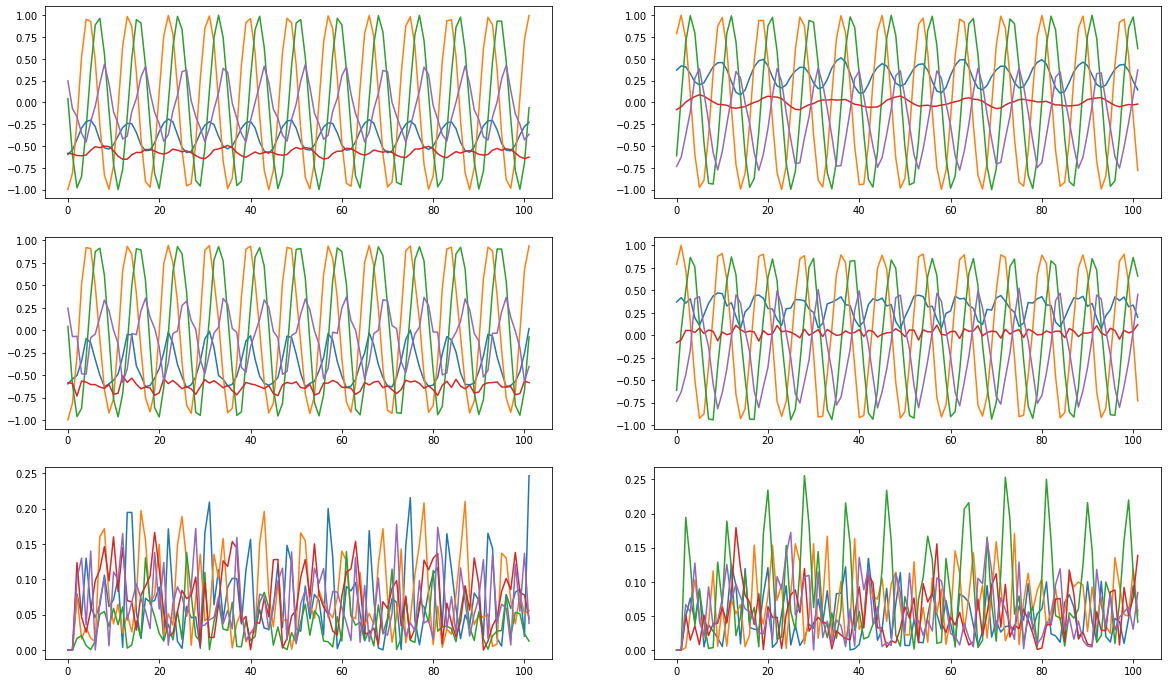

In [29]:
kwargs_opt = {
    "start_from" : 800,
    "nPOD" : nPOD,
    "nLatent" : 100,
    "npredictions" : 100,
    "optimizer_epochs" : 50,
    "dt" : step_size,
    "gan" : gan,
    "cycles" : 10,
    "debug" : debug,
    "disturb" : True
}

optimizer = Optimize(**kwargs_opt)
fld = optimizer.predictDD(training_data,
                           tf.convert_to_tensor(np.array(boundrary_conditions, dtype=np.float32)),
                           dim_steps=added_dims)

show_dims = 5
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(321)
ax1.plot(scaled_training[1,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:show_dims])
ax1 = fig.add_subplot(323)
ax1.plot(fld[0, :, :show_dims])
ax1 = fig.add_subplot(325)
ax1.plot(np.abs(scaled_training[1,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld[0,:, :show_dims]))


ax1 = fig.add_subplot(322)
ax1.plot(scaled_training[2,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims])
ax1 = fig.add_subplot(324)
ax1.plot(fld[1, :, :show_dims])
ax1 = fig.add_subplot(326)
ax1.plot(np.abs(scaled_training[2,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld[1, :, :show_dims]))

plt.show()

Time step: 	 0
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Do

Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 11
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Opti

Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 21
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Opti

Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 31
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Opti

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 41
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch

Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 51
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Opti

Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 61
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Opti

Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 71
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 72
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1

Optimizer epoch: 	 0
Time step: 	 81
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 82
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer e

Time step: 	 91
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 92
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2


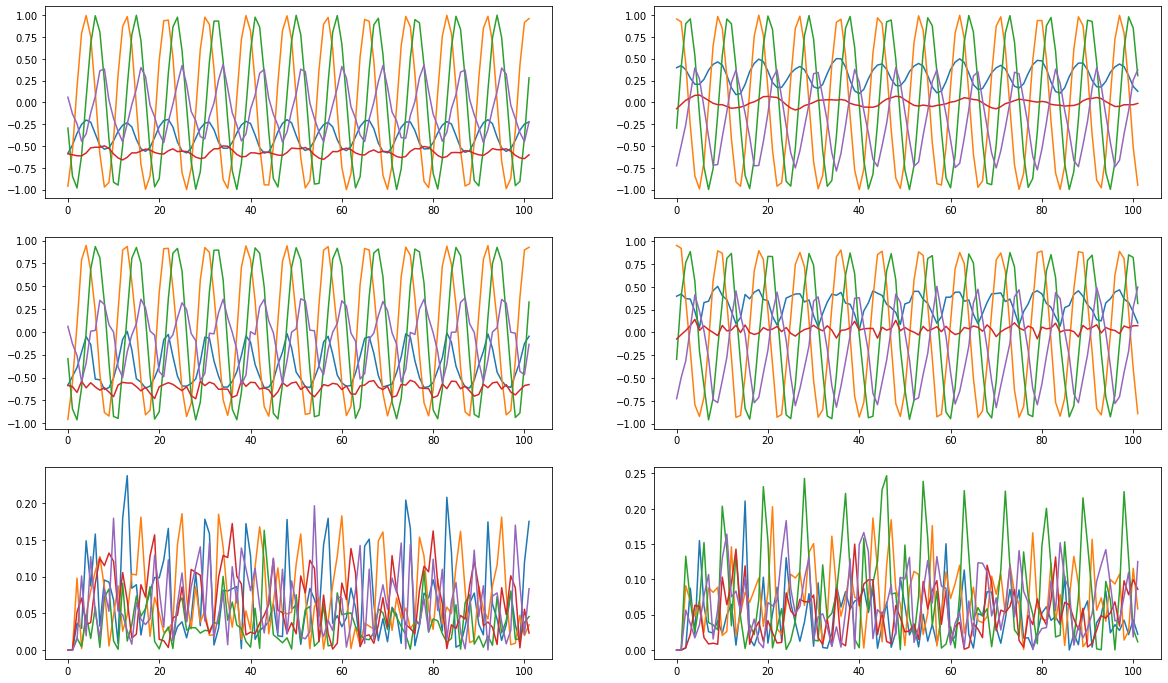

In [23]:
kwargs_opt = {
    "start_from" : 802,
    "nPOD" : nPOD,
    "nLatent" : 100,
    "npredictions" : 100,
    "optimizer_epochs" : 50,
    "dt" : step_size,
    "gan" : gan,
    "cycles" : 10,
    "debug" : debug,
    "disturb" : True
}

optimizer = Optimize(**kwargs_opt)
fld1 = optimizer.predictDD(training_data,
                           tf.convert_to_tensor(np.array(boundrary_conditions, dtype=np.float32)),
                           dim_steps=added_dims)

show_dims = 5
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(321)
ax1.plot(scaled_training[1,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:show_dims])
ax1 = fig.add_subplot(323)
ax1.plot(fld1[0, :, :show_dims])
ax1 = fig.add_subplot(325)
ax1.plot(np.abs(scaled_training[1,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld1[0,:, :show_dims]))


ax1 = fig.add_subplot(322)
ax1.plot(scaled_training[2,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims])
ax1 = fig.add_subplot(324)
ax1.plot(fld1[1, :, :show_dims])
ax1 = fig.add_subplot(326)
ax1.plot(np.abs(scaled_training[2,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld1[1, :, :show_dims]))

plt.show()

In [27]:
a=np.reshape(np.ravel([fld[0],fld1[0]], "F"),[10,-1]).T
b=np.reshape(np.ravel([fld[1],fld1[1]], "F"),[10,-1]).T

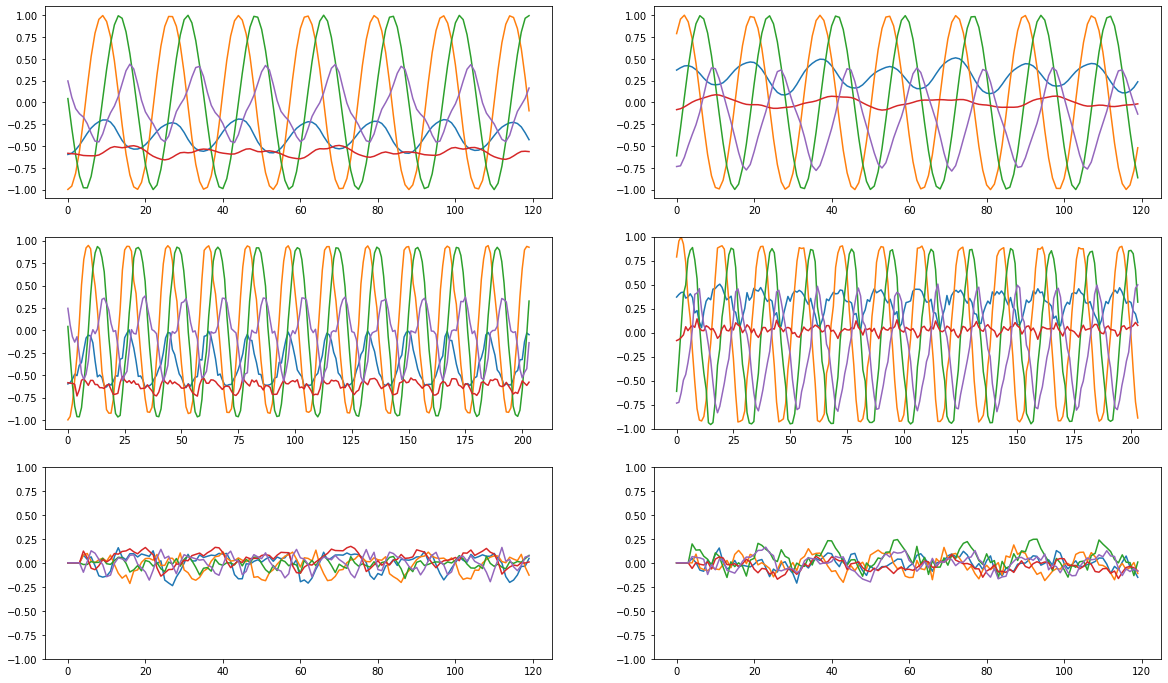

In [28]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(321)
ax1.plot(scaled_training[1, 800:800 + 60*4:2, :show_dims])
ax1 = fig.add_subplot(323)
ax1.plot(a[:,:show_dims])
ax1 = fig.add_subplot(325)
ax1.plot(scaled_training[1, 800:800 + 60*4:2, :show_dims]- a[:120,:show_dims])
ax1.set_ylim([-1,1])

ax1 = fig.add_subplot(322)
ax1.plot(scaled_training[2, 800:800 + 60*4:2, :show_dims])
ax1 = fig.add_subplot(324)
ax1.plot(b[:,:show_dims])
plt.ylim([-1,1])
ax1 = fig.add_subplot(326)
ax1.plot(scaled_training[2, 800:800 + 60*4:2, :show_dims]- b[:120,:show_dims])
ax1.set_ylim([-1,1])

plt.show()

Time step: 	 0
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Do

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 11
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch

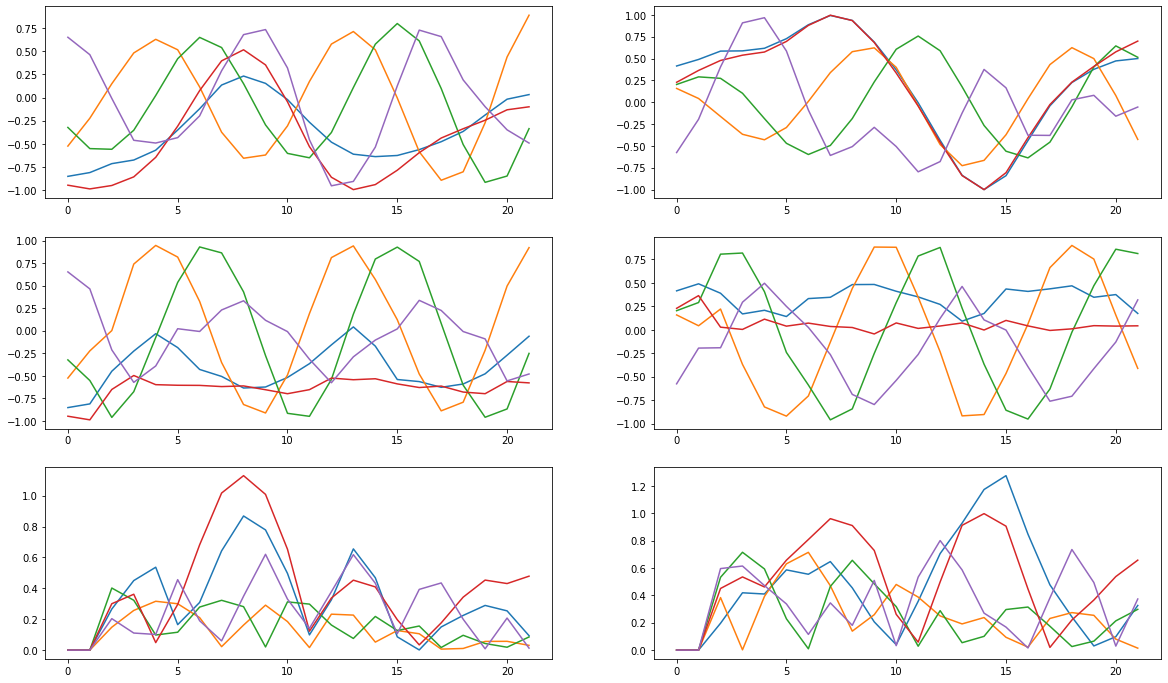

In [31]:
kwargs_opt = {
    "start_from" : 100,
    "nPOD" : nPOD,
    "nLatent" : 100,
    "npredictions" : 20,
    "optimizer_epochs" : 50,
    "dt" : step_size,
    "gan" : gan,
    "cycles" : 10,
    "debug" : debug,
    "disturb" : True
}

optimizer = Optimize(**kwargs_opt)
fld2 = optimizer.predictDD(training_data,
                           tf.convert_to_tensor(np.array(boundrary_conditions, dtype=np.float32)),
                           dim_steps=added_dims)

show_dims = 5
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(321)
ax1.plot(scaled_training[1,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:show_dims])
ax1 = fig.add_subplot(323)
ax1.plot(fld2[0, :, :show_dims])
ax1 = fig.add_subplot(325)
ax1.plot(np.abs(scaled_training[1,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld2[0,:, :show_dims]))


ax1 = fig.add_subplot(322)
ax1.plot(scaled_training[2,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims])
ax1 = fig.add_subplot(324)
ax1.plot(fld2[1, :, :show_dims])
ax1 = fig.add_subplot(326)
ax1.plot(np.abs(scaled_training[2,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld2[1, :, :show_dims]))

plt.show()

In [21]:
a1 = scales[1].inverse_transform(a)
b1 = scales[2].inverse_transform(b)

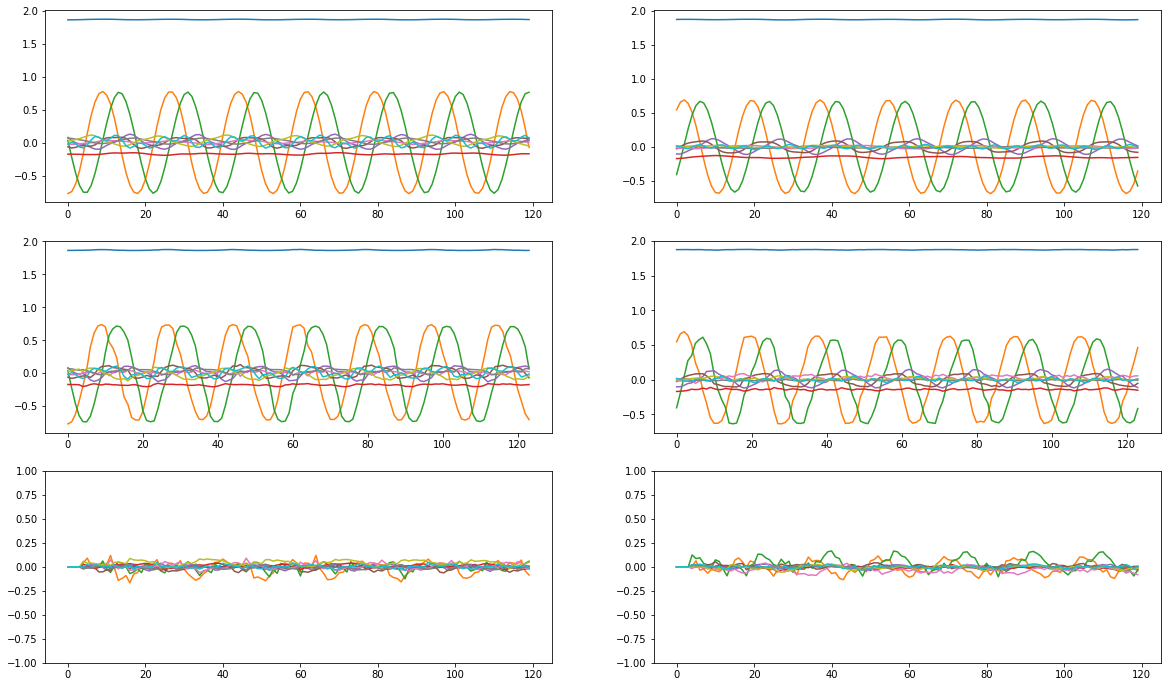

In [22]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(321)
ax1.plot(scales[1].inverse_transform(scaled_training[1, 800:800 + 60*4:2]))
ax1 = fig.add_subplot(323)
ax1.plot(a1[:])
ax1 = fig.add_subplot(325)
ax1.plot(scales[1].inverse_transform(scaled_training[1, 800:800 + 60*4:2])- a1[:120])
ax1.set_ylim([-1,1])

ax1 = fig.add_subplot(322)
ax1.plot(scales[2].inverse_transform(scaled_training[2, 800:800 + 60*4:2]))
ax1 = fig.add_subplot(324)
ax1.plot(b1[:])
ax1 = fig.add_subplot(326)
ax1.plot(scales[2].inverse_transform(scaled_training[2, 800:800 + 60*4:2])- b1[:120])
ax1.set_ylim([-1,1])

plt.show()

In [17]:
pause

NameError: name 'pause' is not defined

In [ ]:
basis = np.load('../data/processed/pod_basis_field_Velocity.npy')

In [ ]:
final_data = []
rect = 18
final_data.append(scales[0].inverse_transform((scaled_training[0,optimizer.start_from+rect:rect+optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:nPOD])).T)
for i in range(2):
    final_data.append(scales[1+i].inverse_transform(flds[i]).T)
    
final_data.append(scales[3].inverse_transform((scaled_training[3,optimizer.start_from+rect:rect+optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:nPOD])).T)

In [ ]:
org_data = []
for i in range(4):
    org_data.append(scales[i].inverse_transform((scaled_training[i,optimizer.start_from+rect:rect+optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:nPOD])).T)

In [ ]:
cutoff = 40
final_data = np.array(final_data)[:,:,:cutoff]
org_data = np.array(org_data)[:,:,:cutoff]

In [ ]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(411)
ax1.plot(final_data[0].T)
ax1 = fig.add_subplot(412)
ax1.plot(final_data[1].T)
ax1 = fig.add_subplot(413)
ax1.plot(final_data[2].T)
ax1 = fig.add_subplot(414)
ax1.plot(final_data[3].T)

plt.show()

In [ ]:
print_data = []

for i in range(4):
    print_data.append((basis[:,:gan.ndims] @ final_data[i]))

print_data = np.array(print_data).reshape([4, 2, 55, 42, 40])
np.save('../data/reconstructed/Velocity_field_predict_DD.npy', print_data )

In [ ]:
org_data_re = []

for i in range(4):
    org_data_re.append(basis[:,:gan.ndims] @ org_data[i])

org_data_re = np.array(org_data_re).reshape([4, 2, 55, 42, 40])
np.save('../data/reconstructed/velocity_field_org_DD.npy', org_data_re )